# MODEL STUDY

In [133]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import axes3d

In [148]:
data = pd.read_csv("output.csv")
data['similar'] = data['similar'].apply(lambda x: x.split('/'))
data['artist_terms'] = data['artist_terms'].apply(lambda x: str(x).split('/'))
data['artist_terms_weights'] = data['artist_terms_weights'].apply(lambda x: str(x).split('/'))

l_max = data['loudness'].max()
l_min = data['loudness'].min()

t_max = data['tempo'].max()
t_min = data['tempo'].min()

data['tempo'] = (data['tempo'] - t_min)/(t_max - t_min)
data['loudness'] = (data['loudness'] - l_min)/(l_max - l_min)

In [149]:
def build_df(input: list, df: pd.core.frame.DataFrame):
    input_songs = [x.upper() for x in input]

    indexes = []
    result = []
    for i in range(len(df)):
        if str(df.iloc[i]['title']).upper() in input_songs:
            result.append(df.iloc[i])
            indexes.append(i)
    for i in indexes:
        df.drop(i, inplace=True)
    return result
    

In [151]:
def distance(song1, song2, alphas = [1,1,1,1,1], term = None):
    """
    song1, song2 : python native lists    format : [artist, title, album, similar, hottness, terms, terms-weights, loudness, tempo]
    alphas : python native list
    
    """
    
    alpha_hot, alpha_loud, alpha_tempo, alpha_similar, alpha_terms = alphas
    artist, title1, album1, similar1, hot1, terms1, weights1, loud1, tempo1 = song1
    artist2, title2, album2, similar2, hot2, terms2, weights2, loud2, tempo2 = song2
    
    if term == 'hot':
        return alpha_hot*abs(hot1-hot2)
    elif term == 'loud':
        return alpha_loud*abs(loud1-loud2)
    elif term == 'tempo':
        return alpha_tempo*abs(tempo1-tempo2)
    elif term == 'similar_artists':
        return alpha_similar*(1 - len([singer for singer in similar1 if singer in similar2])/100)
    #similar artists
    elif term == 'shared_terms':
        shared_terms = [term for term in terms1 if (term in terms2 and term != '')]
        shared_weights1, shared_weights2 = [float(weights1[terms1.index(term)]) for term in shared_terms], [float(weights2[terms2.index(term)]) for term in shared_terms]
        return alpha_terms*sum([0.5*(shared_weights1[i] + shared_weights2[i]) for i in range(len(shared_terms)) ])
    else:
        shared_terms = [term for term in terms1 if (term in terms2 and term != '')]
        shared_weights1, shared_weights2 = [float(weights1[terms1.index(term)]) for term in shared_terms], [float(weights2[terms2.index(term)]) for term in shared_terms]
        artist_terms_weighted = alpha_terms*sum([0.5*(shared_weights1[i] + shared_weights2[i]) for i in range(len(shared_terms)) ])
      
        distance = alpha_hot*abs(hot1-hot2) + alpha_loud*abs(loud1-loud2) + alpha_tempo*abs(tempo1-tempo2)
        distance += alpha_similar*(1 - len([singer for singer in similar1 if singer in similar2])/100)
        distance -= alpha_terms*sum([0.5*(shared_weights1[i] + shared_weights2[i]) for i in range(len(shared_terms)) ])

        return distance
    #print("hot: " + str(alpha_hot*abs(hot1-hot2) )+ " loud: " + str(alpha_loud*abs(loud1-loud2)) + " tempo: ", + str(alpha_tempo*abs(tempo1-tempo2) )+ "similar: " + 
    #str(alpha_similar*(1 - len([singer for singer in similar1 if singer in similar2])/100))+ "terms: " + str(alpha_terms*sum([0.5*(shared_weights1[i] + shared_weights2[i]) for i in range(len(shared_terms)) ])))


In [214]:
def same(song1, song2):
    #returns true if two songs are the same track
    if (song1['title'] == song2['title']) and (song1['artist_name'] == song2['artist_name']):
        return True
    else: return False

# CLUSTER PLOT CODE

In [221]:
k = 3 #number of clusters

#distance would be our defined distance function

def dtos(song, playlist): #distance to other songs (sum of distances to all songs in the playlist
    return np.sum([distance(othersong, song) for othersong in playlist])
    
def find_starting_points(playlist, k):
    all_distances = np.array([dtos(song, playlist) for song in playlist])
    sort_indices = np.argsort(all_distances)
    starting_points = sort_indices[:k]
    return starting_points

def cluster_songs(starting_points, k, pl, song):
    #cluster songs in input playlist into k clusters with respective starting points in starting_points wrt distance to song
    # where song is a recommended song
    # pl is playlist
    names = [[pl[start]['title']] for start in starting_points]
    values = [[distance(pl[start], song)] for start in starting_points]

    start_ids = [(pl[s]['title'],pl[s]['artist_name']) for s in starting_points]
    for plsong in pl:
        if (plsong['title'], plsong['artist_name']) not in start_ids:
            cluster = np.argsort(np.array([distance(plsong, pl[start]) for start in starting_points]))[0]
            #returns index in starting_points which cluster it corresponds to
            names[cluster].append(plsong['title'])
            values[cluster].append(distance(plsong, song))

    min = np.min([distance(song, other) for other in pl])

    rescaled = values
    for i in range(len(values)):
        for j in range(len(values[i])):
            
            rescaled[i][j] = values[i][j] + np.abs(min) + 1
            
    return names, rescaled
    

In [222]:
def cluster_plot(distance_array, songs, size=(7,6)):

    size_of_points = 7

    k = len(distance_array)
    l = len(songs)

    if k != l or [len(kk) for kk in distance_array] != [len(ll) for ll in songs]:
        print("error with the input arrays")
        return 
              
    if k > 4 :
        print("too many clusters")
        return 
         
    x_min, x_max, y_min, y_max = -1, 1, -1, 1
    
    if k>=1:
        
        first = np.array(distance_array[0])
        x_max = np.max(first) + 1
        
    if k>=2:
        
        second = -np.array(distance_array[1])
        x_min = min(second) - 1 
        
    if k>=3:
        
        third = np.array(distance_array[2])
        y_max = np.max(third) + 1  
        
    if k>=4:
        
        fourth = -np.array(distance_array[3])
        y_min = np.min(fourth) - 1
        
    fig = plt.figure(figsize=size)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    plt.plot(np.linspace(x_min, x_max, 100), np.zeros(100), color = 'k')
    
    if k >=3 :
        plt.plot(np.zeros(100), np.linspace(y_min, y_max, 100), color = "k")
        
    plt.plot([x_min - 2, 0, x_max + 2], [y_min - 2, 0, y_max + 2], color = 'r', marker='o', markersize = size_of_points, linestyle="")

    
    if k >= 1 :
        zeros = np.zeros(len(first))

        plt.plot(first, zeros, color='m', marker='o', markersize = size_of_points, linestyle="")
        for i in range(len(first)):
            plt.text(first[i], -0.5, str(i+1), ha='center', va='top', color='m')
        
    if k >= 2 :
        zeros = np.zeros(len(second))

        plt.plot(second, zeros, color='c', marker="o", markersize = size_of_points, linestyle="")
        for i in range(len(second)):
            plt.text(second[i], -0.5, str(i+1), ha='center', va='top', color='c')
    
    if k >= 3 :
        zeros = np.zeros(len(third))

        plt.plot(zeros, third, color='y', marker="o", markersize = size_of_points, linestyle="")
        for i in range(len(third)):
            plt.text(0.2, third[i], str(i+1), ha='center', va='top', color='y')
            
    if k == 4 :
        zeros = np.zeros(len(fourth))

        plt.plot(zeros, fourth, color='g', marker="o", markersize = size_of_points, linestyle="")
        for i in range(len(fourth)):
            plt.text(0.2, fourth[i], str(i+1), ha='center', va='top', color='g')

    plt.show()

    colors = ['\nMagenta', 'Cyan', 'Yellow', 'Green']
    for j in range(k):
        print(colors[j]+":\n")
        for i in range(len(songs[j])):
            print("\t"+str(i+1)+": "+songs[j][i]+" \n")
            

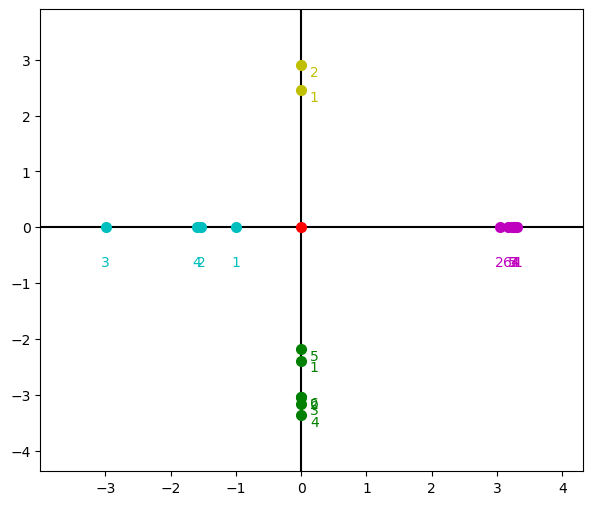


Magenta:

	1: Face the Ashes 

	2: I Didn't Mean To 

	3: The Moon And I (Ordinary Day Album Version) 

	4: Drop of Rain 

	5: Insatiable (Instrumental Version) 

	6: Young Boy Blues 

	7: La Culpa 

Cyan:

	1: Caught In A Dream 

	2: Soul Deep 

	3: Keepin It Real (Skit) 

	4: Floating 

Yellow:

	1: Something Girls 

	2: Pink World 

Green:

	1: Auguri Cha Cha 

	2: Amor De Cabaret 

	3: The Urgency (LP Version) 

	4: Tonight Will Be Alright 

	5: High Tide 

	6: Sohna Nee Sohna Data 



In [223]:
playlist = [data.iloc[i] for i in range(19)]
songrec = data.iloc[20]
k = 4
#def find_starting_points(playlist, k):

#def cluster_songs(starting_points, k, pl, song)
#def cluster_plot(distance_array, songs, size=(7,6)):

names, values = cluster_songs(find_starting_points(playlist,k), k, playlist, songrec)
cluster_plot(values, names)


# CLOSEST N SONGS IN DISTANCE

In [141]:
def closest_n(song, pl, n):
    #song is a recommended song
    #pl playlist from which song was recommended
    #returns closest n songs in an array, closest to furthest

    distances = np.array([distance(song, plsong) for plsong in pl])
    sort_distances = np.argsort(distances)
    n_indices = sort_distances[:n]
    return [playlist[i]['title'] for i in n_indices]

print(closest_n(songrec, playlist, 3))
    

['Something Girls', 'Face the Ashes', 'Pink World']


# Cool bar graph with different components

In [142]:
def bar_graph_data(songrec, pl, alphas = [1,1,1,1,1]):
    hottness = [distance(songrec, song, alphas, 'hot') for song in pl]
    loudness = [distance(songrec, song, alphas, 'loud') for song in pl]
    tempo = [distance(songrec, song, alphas, 'tempo') for song in pl]
    similar_artists = [distance(songrec, song, alphas, 'similar_artists') for song in pl]
    shared_terms = [distance(songrec, song, alphas, 'shared_terms') for song in pl]

    return hottness, loudness, tempo, similar_artists, shared_terms

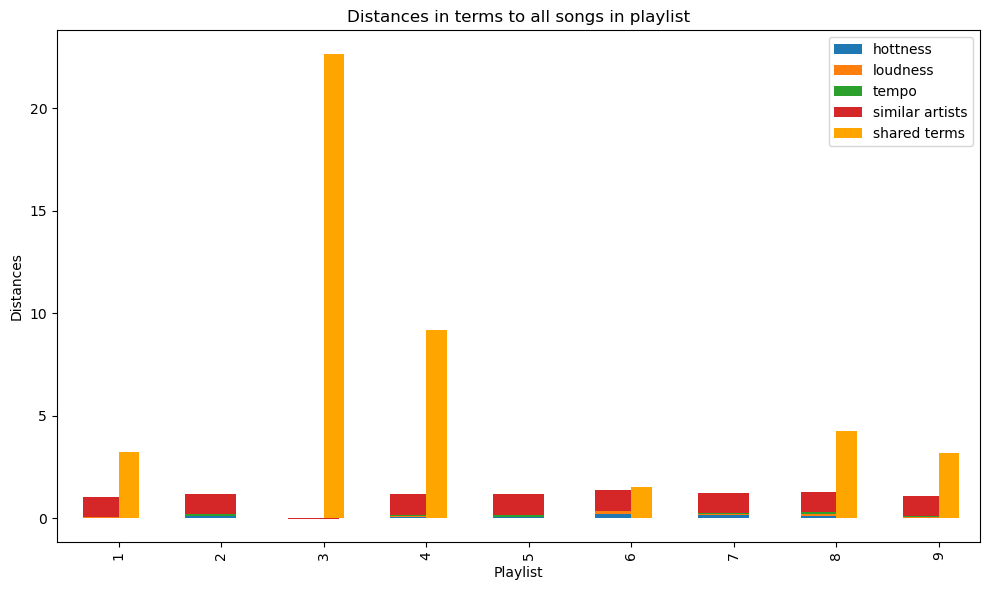

In [143]:

#DATA

# define songrec
# define playlist
alphas = [1,1,1,1,1]

hottness, loudness, tempo, similar_artists, shared_terms = bar_graph_data(songrec, playlist, alphas)
names = []
for song in playlist:
    names.append(song['title'])
data = {
    'Playlist songs' : [1,2,3,4,5,6,7,8,9],
    'hottness' : hottness[1:],
    'loudness' : loudness[1:],
    'tempo' : tempo[1:],
    'similar artists' : similar_artists[1:],
    'shared terms' : shared_terms[1:] #side bar plot
}

df = pd.DataFrame(data)

# Set 'Year' as the index
df.set_index('Playlist songs', inplace=True)

# Plotting the stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the main stacked bars
df[['hottness', 'loudness', 'tempo', 'similar artists']].plot(kind='bar', stacked=True, ax=ax)

# Manually add the separate bar next to each group
bar_width = 0.2
x = np.arange(len(df.index))  # the label locations
separate_bar_x = x + bar_width  # position for the separate bar

ax.bar(separate_bar_x, df['shared terms'], width=bar_width, label='shared terms', color='orange')

# Adding labels and title
ax.set_xlabel('Playlist')
ax.set_ylabel('Distances')
ax.set_title('Distances in terms to all songs in playlist')

# Setting x-ticks to be in the middle of the main and separate bars
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(df.index)

# Adding a legend
ax.legend()

# Adjust layout to make room for the separate bars
plt.tight_layout()

# Show plot
plt.show()
    